<a href="https://colab.research.google.com/github/cindyhps/analisa_sent_3label/blob/main/model_MobNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Env's Needs

In [ ]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install numpy pandas matplotlib scikit-learn pillow tensorflow keras notebook

Library


In [ ]:
import os
import random
import zipfile
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras import Sequential
from sklearn.metrics import hamming_loss
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.utils import Sequence, load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


2024-12-29 11:20:35.239159: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-29 11:20:35.239523: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-29 11:20:35.241478: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-29 11:20:35.247441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735442435.257481 1425982 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735442435.26

Load Data

In [ ]:
#unzip dataset
zip_path = './dataset/fairface-img-margin025-trainval.zip'
extract_to = './dataset/fairface_0.25'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

extracted_files = os.listdir(extract_to)
print("Extracted Files:", extracted_files)

Extracted Files: ['train.csv', 'train', '.ipynb_checkpoints', 'sample', 'val.csv', 'val']


In [ ]:
# Path ke dataset
data_dir = './dataset/fairface_0.25/'
train_dir = './dataset/fairface_0.25/train/'
val_dir = './dataset/fairface_0.25/val/'

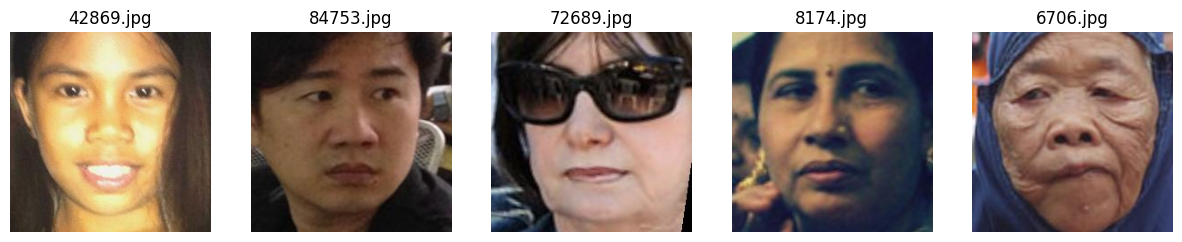

In [ ]:
def show_sample_images(directory, num_images=5):
    # Ambil daftar file dari direktori
    all_files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    # Pilih file secara acak
    sample_files = random.sample(all_files, min(num_images, len(all_files)))

    # Plot gambar
    plt.figure(figsize=(15, 5))
    for i, file_path in enumerate(sample_files):
        img = mpimg.imread(file_path)  # Baca gambar
        plt.subplot(1, len(sample_files), i + 1)  # Buat grid
        plt.imshow(img)
        plt.title(os.path.basename(file_path))  # Nama file sebagai judul
        plt.axis('off')  # Hilangkan sumbu
    plt.show()

# Path ke direktori gambar
train_image_dir = os.path.join(data_dir, 'train')

# Tampilkan contoh gambar dari direktori training
show_sample_images(train_image_dir, num_images=5)

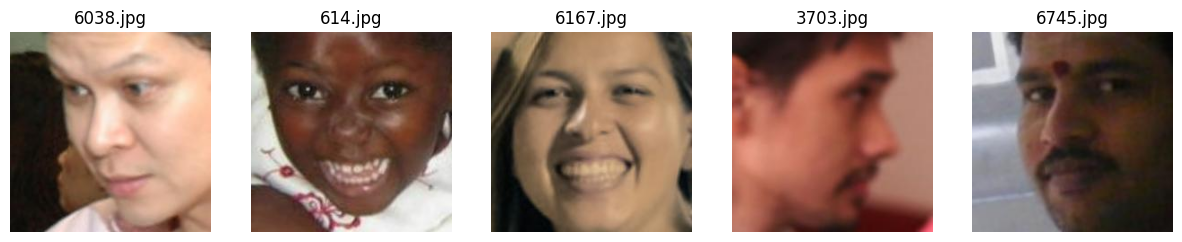

In [ ]:
def show_sample_images(directory, num_images=5):
    # Ambil daftar file dari direktori
    all_files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    # Pilih file secara acak
    sample_files = random.sample(all_files, min(num_images, len(all_files)))

    # Plot gambar
    plt.figure(figsize=(15, 5))
    for i, file_path in enumerate(sample_files):
        img = mpimg.imread(file_path)  # Baca gambar
        plt.subplot(1, len(sample_files), i + 1)  # Buat grid
        plt.imshow(img)
        plt.title(os.path.basename(file_path))  # Nama file sebagai judul
        plt.axis('off')  # Hilangkan sumbu
    plt.show()

# Path ke direktori gambar
val_image_dir = os.path.join(data_dir, 'val')

# Tampilkan contoh gambar dari direktori training
show_sample_images(val_image_dir, num_images=5)

In [ ]:
# Baca metadata (FairFace metadata biasanya ada file CSV)
train_metadata = pd.read_csv(os.path.join(data_dir, 'train.csv'))
val_metadata = pd.read_csv(os.path.join(data_dir, 'val.csv'))

train_metadata['file'] = train_metadata['file'].apply(
    lambda x: os.path.normpath(os.path.join('./dataset/fairface_0.25/train', os.path.basename(x)))
)
val_metadata['file'] = val_metadata['file'].apply(
    lambda x: os.path.normpath(os.path.join('./dataset/fairface_0.25/val', os.path.basename(x)))
)

# Pastikan label tersedia: 'race', 'age', 'gender'
print(train_metadata.head())
print(val_metadata.head())

                                file    age  gender        race  service_test
0  dataset/fairface_0.25/train/1.jpg  50-59    Male  East Asian          True
1  dataset/fairface_0.25/train/2.jpg  30-39  Female      Indian         False
2  dataset/fairface_0.25/train/3.jpg    3-9  Female       Black         False
3  dataset/fairface_0.25/train/4.jpg  20-29  Female      Indian          True
4  dataset/fairface_0.25/train/5.jpg  20-29  Female      Indian          True
                              file    age  gender             race  \
0  dataset/fairface_0.25/val/1.jpg    3-9    Male       East Asian   
1  dataset/fairface_0.25/val/2.jpg  50-59  Female       East Asian   
2  dataset/fairface_0.25/val/3.jpg  30-39    Male            White   
3  dataset/fairface_0.25/val/4.jpg  20-29  Female  Latino_Hispanic   
4  dataset/fairface_0.25/val/5.jpg  20-29    Male  Southeast Asian   

   service_test  
0         False  
1          True  
2          True  
3          True  
4         False  


In [ ]:
# Cek semua file ada
print(train_metadata['file'].apply(os.path.exists).all())  # True jika semua file ada
print(val_metadata['file'].apply(os.path.exists).all())    # True jika semua file ada

# Debug: Tampilkan file yang hilang (jika ada)
missing_train_files = train_metadata[~train_metadata['file'].apply(os.path.exists)]
missing_val_files = val_metadata[~val_metadata['file'].apply(os.path.exists)]

print(f"Missing train files:\n{missing_train_files}")
print(f"Missing val files:\n{missing_val_files}")

True
True
Missing train files:
Empty DataFrame
Columns: [file, age, gender, race, service_test]
Index: []
Missing val files:
Empty DataFrame
Columns: [file, age, gender, race, service_test]
Index: []


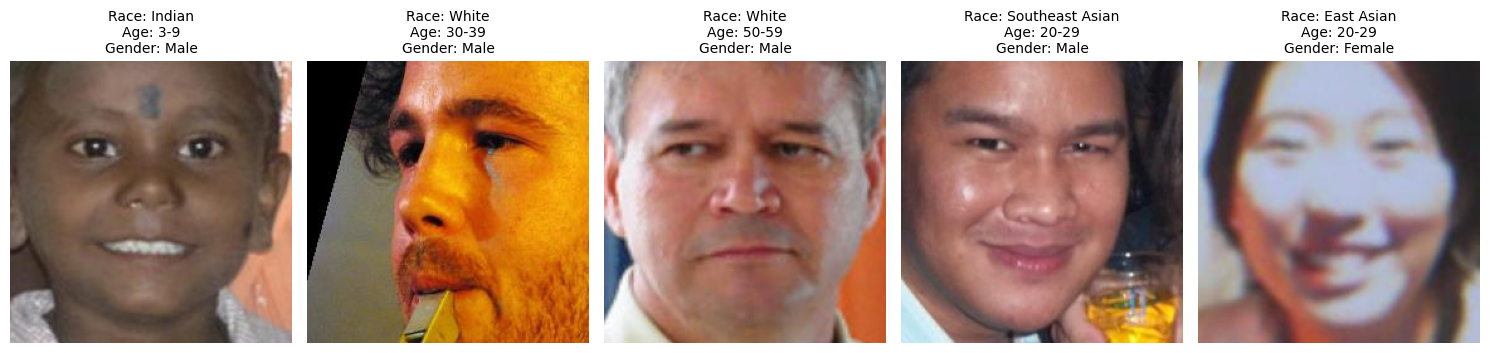

In [ ]:
def display_images_with_labels(dataframe, target_size=(224, 224), num_samples=5):
    # Ambil contoh acak dari dataframe
    sample_data = dataframe.sample(num_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i, (index, row) in enumerate(sample_data.iterrows()):
        # Load gambar
        img = load_img(row['file'], target_size=target_size)
        img_array = img_to_array(img) / 255.0

        # Tampilkan gambar
        axes[i].imshow(img_array)
        axes[i].axis('off')  # Hilangkan sumbu

        # Tambahkan label di bawah gambar
        label = f"Race: {row['race']}\nAge: {row['age']}\nGender: {row['gender']}"
        axes[i].set_title(label, fontsize=10)

    plt.tight_layout()
    plt.show()

# Tampilkan 5 contoh dari train_metadata
display_images_with_labels(train_metadata, target_size=(224, 224), num_samples=5)


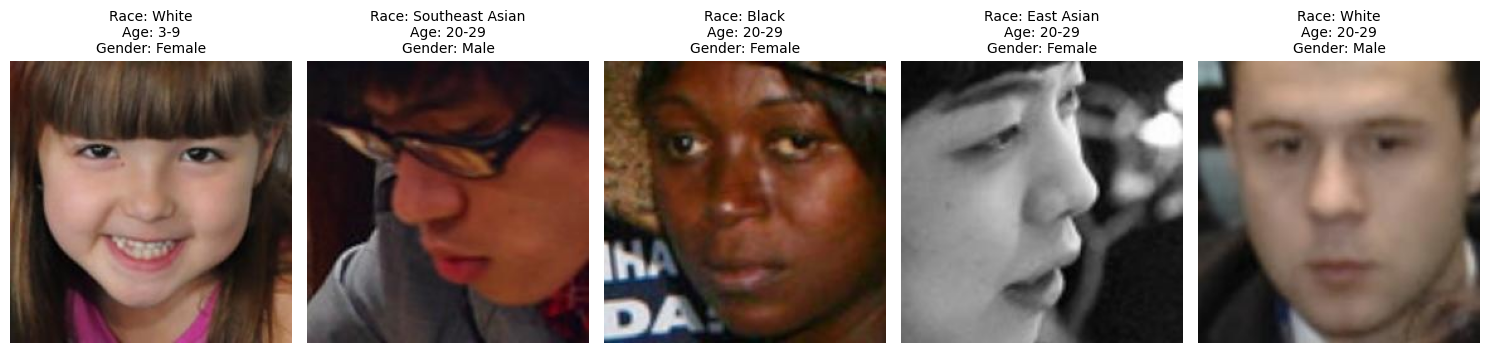

In [ ]:
def display_images_with_labels(dataframe, target_size=(224, 224), num_samples=5):
    # Ambil contoh acak dari dataframe
    sample_data = dataframe.sample(num_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i, (index, row) in enumerate(sample_data.iterrows()):
        # Load gambar
        img = load_img(row['file'], target_size=target_size)
        img_array = img_to_array(img) / 255.0

        # Tampilkan gambar
        axes[i].imshow(img_array)
        axes[i].axis('off')  # Hilangkan sumbu

        # Tambahkan label di bawah gambar
        label = f"Race: {row['race']}\nAge: {row['age']}\nGender: {row['gender']}"
        axes[i].set_title(label, fontsize=10)

    plt.tight_layout()
    plt.show()

# Tampilkan 5 contoh dari train_metadata
display_images_with_labels(val_metadata, target_size=(224, 224), num_samples=5)


In [ ]:
print(train_metadata['file'].apply(os.path.exists).all())  # Harus menghasilkan True
print(val_metadata['file'].apply(os.path.exists).all())  # Harus menghasilkan True

True
True


In [ ]:
print(os.path.exists(train_metadata.iloc[0]['file']))
print(os.path.exists(val_metadata.iloc[0]['file']))

True
True


Parameters

In [ ]:
IMG_SIZE = 224  # Resolusi gambar untuk MobileNetV2
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-5

In [ ]:
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    # tf.keras.layers.RandomContrast(0.2),
    # tf.keras.layers.RandomBrightness(0.2),
    # tf.keras.layers.RandomHeight(0.2),
    # tf.keras.layers.RandomWidth(0.2)
])

2024-12-29 11:20:46.163280: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Metadata + Generator Data Prepared + Data Augmentasi

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, dataframe, target_size=(224, 224), batch_size=BATCH_SIZE, shuffle=True):
        self.dataframe = dataframe
        self.target_size = target_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # Jumlah batch per epoch
        return len(self.dataframe) // self.batch_size

    def __getitem__(self, index):
        # Ambil indeks data untuk batch
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.dataframe.iloc[indices]
        return self.__data_generation(batch_data)

    def on_epoch_end(self):
        # Mengacak data setelah setiap epoch
        self.indices = np.arange(len(self.dataframe))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_data):
        # Load gambar dan label untuk batch
        images = []
        labels_race = []
        labels_age = []
        labels_gender = []

        for _, row in batch_data.iterrows():
            # Load gambar
            img = load_img(row['file'], target_size=self.target_size)
            img_array = img_to_array(img) / 255.0  # Normalisasi
            images.append(img_array)

            # Tambahkan label
            labels_race.append(row['race'])
            labels_age.append(row['age'])
            labels_gender.append(row['gender'])

        # Ubah menjadi numpy array
        images = np.array(images)
        labels_race = np.array(labels_race)
        labels_age = np.array(labels_age)
        labels_gender = np.array(labels_gender)

        # Kembalikan data dan label
        return images, [labels_race, labels_age, labels_gender]

# Inisialisasi generator untuk training dan validation
train_generator = DataGenerator(train_metadata, target_size=(224, 224), batch_size=BATCH_SIZE)
val_generator = DataGenerator(val_metadata, target_size=(224, 224), batch_size=BATCH_SIZE)

In [ ]:
# Jika menggunakan flow_from_dataframe, gunakan .samples
print("Jumlah data pada train_generator:", {len(train_generator)})
print("Jumlah data pada val_generator:", {len(val_generator)})

# Contoh data pada train_metadata
print("Contoh data pada train_metadata:")
print(train_metadata.head())
print(val_metadata.head())

# Contoh file gambar di direktori 'train'
train_dir = os.path.join(data_dir, 'train')
print("Contoh file gambar yang ada di direktori:")
print(os.listdir(train_dir)[:5])  # Menampilkan 5 file pertama

# Contoh file gambar di direktori 'val'
val_dir = os.path.join(data_dir, 'val')
print("Contoh file gambar yang ada di direktori:")
print(os.listdir(val_dir)[:5])  # Menampilkan 5 file pertama

Jumlah data pada train_generator: {2710}
Jumlah data pada val_generator: {342}
Contoh data pada train_metadata:
                                file    age  gender        race  service_test
0  dataset/fairface_0.25/train/1.jpg  50-59    Male  East Asian          True
1  dataset/fairface_0.25/train/2.jpg  30-39  Female      Indian         False
2  dataset/fairface_0.25/train/3.jpg    3-9  Female       Black         False
3  dataset/fairface_0.25/train/4.jpg  20-29  Female      Indian          True
4  dataset/fairface_0.25/train/5.jpg  20-29  Female      Indian          True
                              file    age  gender             race  \
0  dataset/fairface_0.25/val/1.jpg    3-9    Male       East Asian   
1  dataset/fairface_0.25/val/2.jpg  50-59  Female       East Asian   
2  dataset/fairface_0.25/val/3.jpg  30-39    Male            White   
3  dataset/fairface_0.25/val/4.jpg  20-29  Female  Latino_Hispanic   
4  dataset/fairface_0.25/val/5.jpg  20-29    Male  Southeast Asian   


In [ ]:
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

# Jumlah file gambar
train_image_files = glob(os.path.join(train_dir, '*.jpg'))
val_image_files = glob(os.path.join(val_dir, '*.jpg'))

In [ ]:
# #gender
train_metadata['gender'] = train_metadata['gender'].map({'Male': 0, 'Female': 1})
val_metadata['gender'] = val_metadata['gender'].map({'Male': 0, 'Female': 1})

train_metadata['gender'] = train_metadata['gender'].astype(np.float32)
val_metadata['gender'] = val_metadata['gender'].astype(np.float32)

train_metadata['gender'] = np.expand_dims(train_metadata['gender'], axis=-1)
val_metadata['gender'] = np.expand_dims(val_metadata['gender'], axis=-1)

In [ ]:
#gender
train_metadata['gender'] = train_metadata['gender'].astype(np.float32)
train_metadata['gender'] = np.expand_dims(train_metadata['gender'], axis=-1)
val_metadata['gender'] = val_metadata['gender'].astype(np.float32)
val_metadata['gender'] = np.expand_dims(val_metadata['gender'], axis=-1)


In [ ]:
print("Shape gender target (train):", train_metadata['gender'].shape)
print("Shape gender target (val):", val_metadata['gender'].shape)

Shape gender target (train): (86744,)
Shape gender target (val): (10954,)


In [ ]:
#age
age_mapping = {
    '3-9': 0, '10-19': 1, '20-29': 2, '30-39': 3,
    '40-49': 4, '50-59': 5, '60-69': 6, '70+': 7
}
train_metadata['age'] = train_metadata['age'].map(age_mapping)
val_metadata['age'] = val_metadata['age'].map(age_mapping)


In [ ]:
#race
race_encoder = LabelEncoder()
train_metadata['race'] = race_encoder.fit_transform(train_metadata['race'])
val_metadata['race'] = race_encoder.transform(val_metadata['race'])

In [ ]:
# train_metadata['age'] = train_metadata['age'].fillna('3-9')
# val_metadata['age'] = val_metadata['age'].fillna('3-9')


In [ ]:
print("Nilai unik dalam train_metadata['age']:", train_metadata['age'].unique())
print("Nilai unik dalam val_metadata['age']:", val_metadata['age'].unique())


Nilai unik dalam train_metadata['age']: [ 5.  3.  0.  2.  4.  1.  6. nan]
Nilai unik dalam val_metadata['age']: [ 0.  5.  3.  2. nan  4.  1.  6.]


In [ ]:
mode_age_train = train_metadata['age'].mode()[0]
mode_age_val = val_metadata['age'].mode()[0]

train_metadata['age'] = train_metadata['age'].fillna(mode_age_train).astype(np.int32)
val_metadata['age'] = val_metadata['age'].fillna(mode_age_val).astype(np.int32)


In [ ]:
print(train_metadata['age'].isnull().sum())  # Cek jumlah nilai NaN
print(val_metadata['age'].isnull().sum())
print(train_metadata['age'].unique())  # Cek nilai unik di kolom age
print(val_metadata['age'].unique())


0
0
[5 3 0 2 4 1 6]
[0 5 3 2 4 1 6]


In [ ]:
print(train_metadata.dtypes)  # Pastikan semua kolom target bertipe numerik
print(val_metadata.dtypes)
print(train_metadata.head())
print(val_metadata.head())


file             object
age               int32
gender          float32
race              int64
service_test       bool
dtype: object
file             object
age               int32
gender          float32
race              int64
service_test       bool
dtype: object
                                file  age  gender  race  service_test
0  dataset/fairface_0.25/train/1.jpg    5     0.0     1          True
1  dataset/fairface_0.25/train/2.jpg    3     1.0     2         False
2  dataset/fairface_0.25/train/3.jpg    0     1.0     0         False
3  dataset/fairface_0.25/train/4.jpg    2     1.0     2          True
4  dataset/fairface_0.25/train/5.jpg    2     1.0     2          True
                              file  age  gender  race  service_test
0  dataset/fairface_0.25/val/1.jpg    0     0.0     1         False
1  dataset/fairface_0.25/val/2.jpg    5     1.0     1          True
2  dataset/fairface_0.25/val/3.jpg    3     0.0     6          True
3  dataset/fairface_0.25/val/4.jpg    2 

In [ ]:
train_metadata['age'] = train_metadata['age'].astype(np.int32)
val_metadata['age'] = val_metadata['age'].astype(np.int32)


In [ ]:
# train_metadata['age'] = train_metadata['age'].map(age_mapping).astype(np.int32)
# train_metadata['race'] = race_encoder.fit_transform(train_metadata['race']).astype(np.int32)
# val_metadata['age'] = val_metadata['age'].map(age_mapping).astype(np.int32)
# val_metadata['race'] = race_encoder.transform(val_metadata['race']).astype(np.int32)

In [ ]:
print("Train Dir Files:", len(os.listdir(train_dir)))
print("Validation Dir Files:", len(os.listdir(val_dir)))

Train Dir Files: 86744
Validation Dir Files: 10954


Preprocessing Data

In [ ]:
# Data augmentation untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Rescale untuk validation
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# for path in train_metadata['file']:
#     try:
#         img = Image.open(path)
#         img.verify()
#     except Exception as e:
#         print(f"Invalid file: {path} - {e}")

In [ ]:
# for path in val_metadata['file']:
#     try:
#         img = Image.open(path)
#         img.verify()
#     except Exception as e:
#         print(f"Invalid file: {path} - {e}")

Load Pretrained Model (MobileNetV2)

In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)

# Freeze pretrained layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# x = Flatten()(base_model.output)

# # Freeze pretrained layers
# for layer in base_model.layers:
#     layer.trainable = False

Build Model

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

# Output untuk race
output_race = Dense(len(race_encoder.classes_), activation='softmax', name='race')(x)

# Output untuk age
output_age = Dense(len(age_mapping), activation='softmax', name='age')(x)

# Output untuk gender
output_gender = Dense(1, activation='sigmoid', name='gender')(x)

# Gabungkan output
model = Model(inputs=base_model.input, outputs=[output_race, output_age, output_gender])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,070,067 (15.53 MB)

 Trainable params: 20,496 (80.06 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss={
        'race': 'sparse_categorical_crossentropy',
        'gender': 'binary_crossentropy',
        'age': 'sparse_categorical_crossentropy',
    },
    # loss_weights={
    #     'race': 2.0,    # Beri bobot lebih tinggi karena lebih sulit
    #     'gender': 1.0,  # Bobot normal
    #     'age': 1.5,     # Bobot moderat
    # },
    metrics={
        'race': 'accuracy',
        'gender': 'accuracy',
        'age': 'accuracy',
    }
)

Train Model + Metadata

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
# val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_metadata,
    directory=None,
    x_col='file',
    y_col=None,  # Tidak langsung menghasilkan label
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode=None  # Tidak ada class_mode
)

Found 86744 validated image filenames.


In [ ]:
# Validation generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_metadata,
    directory=None,
    x_col='file',
    y_col=None,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode=None
)

Found 10954 validated image filenames.


In [ ]:
steps_per_epoch = len(train_generator.filenames) // BATCH_SIZE
validation_steps = len(val_generator.filenames) // BATCH_SIZE

In [ ]:
batch = next(train_generator)
print(f"Input batch shape: {batch[0].shape}")
print(f"Output batch type: {type(batch[1])}")
print(f"Output batch sample: {batch[1]}")
print(f"Updated Output batch sample: {batch[1]}")

Input batch shape: (224, 224, 3)
Output batch type: <class 'numpy.ndarray'>
Output batch sample: [[[0.04313726 0.02745098 0.01568628]
  [0.04313726 0.02745098 0.01568628]
  [0.03529412 0.01960784 0.00784314]
  ...
  [0.03137255 0.01960784 0.        ]
  [0.03529412 0.01568628 0.        ]
  [0.03529412 0.01568628 0.        ]]

 [[0.04313726 0.02745098 0.01568628]
  [0.03921569 0.02352941 0.01176471]
  [0.03529412 0.01960784 0.00784314]
  ...
  [0.03137255 0.01960784 0.        ]
  [0.03529412 0.01568628 0.        ]
  [0.03529412 0.01568628 0.        ]]

 [[0.04313726 0.02745098 0.01568628]
  [0.03921569 0.02352941 0.01176471]
  [0.03529412 0.01960784 0.00784314]
  ...
  [0.03137255 0.01960784 0.        ]
  [0.03529412 0.01568628 0.        ]
  [0.03529412 0.01568628 0.        ]]

 ...

 [[0.29411766 0.08627451 0.0627451 ]
  [0.2901961  0.09411766 0.06666667]
  [0.2901961  0.09019608 0.07450981]
  ...
  [0.14901961 0.07058824 0.02745098]
  [0.16078432 0.07450981 0.02352941]
  [0.16470589 0.

In [ ]:
batch = next(val_generator)
print(f"Input batch shape: {batch[0].shape}")
print(f"Output batch type: {type(batch[1])}")
print(f"Output batch sample: {batch[1]}")
print(f"Updated Output batch sample: {batch[1]}")

Input batch shape: (224, 224, 3)
Output batch type: <class 'numpy.ndarray'>
Output batch sample: [[[0.38823533 0.3137255  0.29803923]
  [0.38431376 0.30980393 0.29411766]
  [0.37647063 0.3019608  0.28627452]
  ...
  [0.4431373  0.34117648 0.28235295]
  [0.427451   0.3254902  0.26666668]
  [0.41960788 0.31764707 0.25882354]]

 [[0.37647063 0.3019608  0.28627452]
  [0.36862746 0.29411766 0.2784314 ]
  [0.36078432 0.28627452 0.27058825]
  ...
  [0.43137258 0.32941177 0.27058825]
  [0.4156863  0.3137255  0.25490198]
  [0.40784317 0.30588236 0.24705884]]

 [[0.35686275 0.28235295 0.26666668]
  [0.3529412  0.2784314  0.2627451 ]
  [0.34509805 0.27058825 0.25490198]
  ...
  [0.41176474 0.30980393 0.2509804 ]
  [0.40000004 0.29803923 0.2392157 ]
  [0.39607847 0.29411766 0.23529413]]

 ...

 [[0.32941177 0.29411766 0.3137255 ]
  [0.3254902  0.2901961  0.30980393]
  [0.3254902  0.2901961  0.30980393]
  ...
  [0.3803922  0.30588236 0.28235295]
  [0.38431376 0.30980393 0.28627452]
  [0.38431376 0.

In [ ]:
print(train_metadata.head())
print(val_metadata.head())

                                file  age  gender  race  service_test
0  dataset/fairface_0.25/train/1.jpg    5     0.0     1          True
1  dataset/fairface_0.25/train/2.jpg    3     1.0     2         False
2  dataset/fairface_0.25/train/3.jpg    0     1.0     0         False
3  dataset/fairface_0.25/train/4.jpg    2     1.0     2          True
4  dataset/fairface_0.25/train/5.jpg    2     1.0     2          True
                              file  age  gender  race  service_test
0  dataset/fairface_0.25/val/1.jpg    0     0.0     1         False
1  dataset/fairface_0.25/val/2.jpg    5     1.0     1          True
2  dataset/fairface_0.25/val/3.jpg    3     0.0     6          True
3  dataset/fairface_0.25/val/4.jpg    2     1.0     3          True
4  dataset/fairface_0.25/val/5.jpg    2     0.0     5         False


In [ ]:
# def create_tf_dataset(dataframe, batch_size):
#     def generator_fn():
#         for _, row in dataframe.iterrows():
#             img = load_img(row['file'], target_size=(224, 224))
#             img_array = img_to_array(img) / 255.0
#             yield img_array, {"race": row['race'], "age": row['age'], "gender": row['gender']}

#     return tf.data.Dataset.from_generator(
#         generator_fn,
#         output_signature=(
#             tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
#             {
#                 "race": tf.TensorSpec(shape=(), dtype=tf.int32),
#                 "age": tf.TensorSpec(shape=(), dtype=tf.int32),
#                 "gender": tf.TensorSpec(shape=(), dtype=tf.float32)
#             }
#         )
#     )


In [ ]:
def generator_fn(dataframe):
    for _, row in dataframe.iterrows():
        # Load dan preprocess gambar
        img = load_img(row['file'], target_size=(224, 224))
        img_array = img_to_array(img) / 255.0

        # Format label sebagai dictionary, pastikan bentuknya benar
        labels = {
            "race": np.array(row['race'], dtype=np.int32),  # Bentuk scalar
            "age": np.array(row['age'], dtype=np.int32),    # Bentuk scalar
            "gender": np.array([row['gender']], dtype=np.float32)  # Bentuk (1,)
        }
        yield img_array, labels

In [ ]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: generator_fn(train_metadata),
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        {
            "race": tf.TensorSpec(shape=(), dtype=tf.int32),  # Scalar
            "age": tf.TensorSpec(shape=(), dtype=tf.int32),   # Scalar
            "gender": tf.TensorSpec(shape=(1,), dtype=tf.float32)  # Vector (1,)
        }
    )
)

In [ ]:
val_dataset = tf.data.Dataset.from_generator(
    lambda: generator_fn(val_metadata),
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        {
            "race": tf.TensorSpec(shape=(), dtype=tf.int32),  # Scalar
            "age": tf.TensorSpec(shape=(), dtype=tf.int32),   # Scalar
            "gender": tf.TensorSpec(shape=(1,), dtype=tf.float32)  # Vector (1,)
        }
    )
)

In [ ]:
# def generator_to_tfdata(generator):
#     def gen():
#         for x, y in generator:
#             yield x, y
#     return tf.data.Dataset.from_generator(
#         gen,
#         output_signature=(
#             tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input shape
#             {
#                 "race": tf.TensorSpec(shape=(None,), dtype=tf.int32),     # Label race
#                 "age": tf.TensorSpec(shape=(None,), dtype=tf.int32),      # Label age
#                 "gender": tf.TensorSpec(shape=(None,), dtype=tf.float32)  # Label gender
#             }
#         )
#     )

# train_dataset = generator_to_tfdata(train_generator)
# val_dataset = generator_to_tfdata(val_generator)

In [ ]:
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [ ]:
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Labels:", labels)


Image batch shape: (32, 224, 224, 3)
Labels: {'race': <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 2, 0, 2, 2, 6, 4, 2, 6, 4, 1, 1, 3, 2, 2, 6, 5, 5, 0, 5, 2, 4,
       0, 6, 6, 0, 6, 6, 2, 0, 0, 1], dtype=int32)>, 'age': <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([5, 3, 0, 2, 2, 2, 4, 3, 1, 3, 5, 2, 2, 1, 6, 3, 2, 4, 2, 5, 2, 3,
       2, 3, 2, 3, 5, 1, 2, 2, 4, 1], dtype=int32)>, 'gender': <tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.]], dtype=float32)>}


2024-12-29 11:20:47.616010: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# for batch_images, batch_labels in train_dataset.take(1):
#     outputs = model(batch_images)
#     print("Model outputs:", outputs)


In [ ]:
x, y = batch[0], batch[1]  # Ambil elemen dari list
print("Input shape:", x.shape)  # (batch_size, IMG_SIZE, IMG_SIZE, 3)
print("Race label shape:", y[0].shape)
print("Age label shape:", y[1].shape)
print("Gender label shape:", y[2].shape)

Input shape: (224, 224, 3)
Race label shape: (224, 3)
Age label shape: (224, 3)
Gender label shape: (224, 3)


In [ ]:
batch = train_generator[0]
print("Type of batch:", type(batch))  # Tipe data batch
print("Length of batch:", len(batch))  # Panjang batch jika batch adalah list
print("Batch content:", batch)  # Tampilkan isi batch untuk analisis


Type of batch: <class 'numpy.ndarray'>
Length of batch: 32
Batch content: [[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.47058827 0.34509805 0.19215688]
   [0.47058827 0.34509805 0.18431373]
   [0.47058827 0.34509805 0.18431373]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.49411768 0.36862746 0.21568629]
   [0.49803925 0.37254903 0.21176472]
   [0.5019608  0.37647063 0.21568629]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.5137255  0.38823533 0.23529413]
   [0.5254902  0.40000004 0.2392157 ]
   [0.53333336 0.40784317 0.24705884]]

  ...

  [[0.02352941 0.         0.        ]
   [0.01568628 0.         0.        ]
   [0.00392157 0.         0.        ]
   ...
   [0.49411768 0.38431376 0.3372549 ]
   [0.48627454 0.37647063 0.32941177]
   [0.48235

In [ ]:
batch = val_generator[0]
print("Type of batch:", type(batch))  # Tipe data batch
print("Length of batch:", len(batch))  # Panjang batch jika batch adalah list
print("Batch content:", batch)  # Tampilkan isi batch untuk analisis


Type of batch: <class 'numpy.ndarray'>
Length of batch: 32
Batch content: [[[[0.15294118 0.16078432 0.15686275]
   [0.15294118 0.16078432 0.15686275]
   [0.15294118 0.16078432 0.15686275]
   ...
   [0.8470589  0.7607844  0.6666667 ]
   [0.83921576 0.74509805 0.6509804 ]
   [0.8313726  0.7372549  0.6431373 ]]

  [[0.16862746 0.1764706  0.17254902]
   [0.16470589 0.17254902 0.16862746]
   [0.16078432 0.16862746 0.16470589]
   ...
   [0.8313726  0.7372549  0.6431373 ]
   [0.8352942  0.7411765  0.64705884]
   [0.81568635 0.72156864 0.627451  ]]

  [[0.18823531 0.19607845 0.19215688]
   [0.18039216 0.18823531 0.18431373]
   [0.16862746 0.1764706  0.17254902]
   ...
   [0.854902   0.75294125 0.6627451 ]
   [0.86666673 0.76470596 0.6745098 ]
   [0.8470589  0.74509805 0.654902  ]]

  ...

  [[0.06666667 0.07450981 0.0627451 ]
   [0.07843138 0.08627451 0.07450981]
   [0.09019608 0.09803922 0.08627451]
   ...
   [0.5882353  0.49411768 0.40000004]
   [0.5921569  0.49411768 0.40784317]
   [0.61176

In [ ]:
assert train_metadata['file'].apply(os.path.exists).all()
assert val_metadata['file'].apply(os.path.exists).all()


In [ ]:
for output in model.outputs:
    print(f"Output name: {output.name}, shape: {output.shape}")


Output name: keras_tensor_241, shape: (None, 7)
Output name: keras_tensor_242, shape: (None, 8)
Output name: keras_tensor_243, shape: (None, 1)


In [ ]:
def format_dataset(x, y):
    return x, {"race": y["race"], "age": y["age"], "gender": y["gender"]}

train_dataset = train_dataset.map(format_dataset)
val_dataset = val_dataset.map(format_dataset)


In [ ]:
print(train_dataset.element_spec)

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), {'race': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'age': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'gender': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)})


In [ ]:
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Race label shape:", labels['race'].shape)
    print("Age label shape:", labels['age'].shape)
    print("Gender label shape:", labels['gender'].shape)

for batch_images, batch_labels in train_dataset.take(1):  # Tanpa .batch(BATCH_SIZE)
    outputs = model(batch_images)
    print("Model outputs:", outputs)



Image batch shape: (32, 224, 224, 3)
Race label shape: (32,)
Age label shape: (32,)
Gender label shape: (32, 1)


2024-12-29 11:20:47.866585: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model outputs: [<tf.Tensor: shape=(32, 7), dtype=float32, numpy=
array([[0.18330422, 0.15132271, 0.2024855 , 0.08327858, 0.12221662,
        0.10352272, 0.15386964],
       [0.1834996 , 0.15117726, 0.20209533, 0.08328664, 0.1220402 ,
        0.10355785, 0.15434311],
       [0.18332206, 0.15144327, 0.20219657, 0.08333147, 0.12206168,
        0.10351606, 0.15412897],
       [0.1832517 , 0.15150967, 0.20248836, 0.08329329, 0.12208165,
        0.10354232, 0.15383294],
       [0.18369475, 0.15103076, 0.20194054, 0.08332963, 0.12188949,
        0.10364796, 0.15446694],
       [0.18347043, 0.15108295, 0.20222467, 0.08327204, 0.12209614,
        0.10350019, 0.15435348],
       [0.18321711, 0.15136056, 0.20266928, 0.08342241, 0.12203353,
        0.10344005, 0.1538571 ],
       [0.1834325 , 0.15122752, 0.2022945 , 0.08328512, 0.122127  ,
        0.10354966, 0.15408371],
       [0.18342783, 0.15129784, 0.20224358, 0.08329485, 0.12211048,
        0.10357996, 0.15404548],
       [0.18332645, 0.1514

In [ ]:
# Hitung bobot untuk ras
class_weights_race = compute_class_weight(
    'balanced',
    classes=np.unique(train_metadata['race']),
    y=train_metadata['race']
)

class_weights = {'race': dict(enumerate(class_weights_race))}

In [ ]:
def augment_batch(images, labels):
    # Terapkan augmentasi hanya pada batch gambar
    images = data_augmentation(images)
    return images, labels

In [ ]:
train_dataset = train_dataset.map(augment_batch)

In [ ]:
train_dataset = train_dataset.repeat()
val_dataset = val_dataset.repeat()

In [ ]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    steps_per_epoch=len(train_metadata) // BATCH_SIZE,
    validation_steps=len(val_metadata) // BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler],
    # class_weight=class_weights # Include callbacks here
)

Epoch 1/10
 127/2710 ━━━━━━━━━━━━━━━━━━━━ 18:35 432ms/step - age_accuracy: 0.1576 - age_loss: 2.0900 - gender_accuracy: 0.5092 - gender_loss: 0.6979 - loss: 4.7892 - race_accuracy: 0.1589 - race_loss: 2.0013

Save Model + Load Predict

In [ ]:
model.save('fairface_mobilenetv2_model.h5')

In [ ]:
# Load model
model = load_model('fairface_mobilenetv2_model.h5')

Evaluate & Visualize

In [ ]:
# results = model.evaluate(val_dataset)
# print("Validation Results:", results)

In [ ]:
# Definisikan mapping untuk race, age, dan gender
race_labels = {0: "White", 1: "Black", 2: "East Asian", 3: "Southeast Asian", 4: "Indian", 5: "Middle Eastern", 6: "Latino/Hispanic"}
age_labels = {0: "0-2", 1: "3-9", 2: "10-19", 3: "20-29", 4: "30-39", 5: "40-49", 6: "50-59", 7: "60-69", 8: "70+"}
gender_labels = {0: "Male", 1: "Female"}

# Loop untuk menampilkan prediksi dengan label deskriptif
for x_batch, y_batch in val_dataset.take(1):  # Ambil satu batch
    predictions = model.predict(x_batch)

    # Tampilkan beberapa gambar dengan prediksi dan label asli
    for i in range(5):  # Tampilkan 5 gambar pertama
        # Prediksi
        pred_race = np.argmax(predictions[0][i])
        pred_age = np.argmax(predictions[1][i])
        pred_gender = 1 if predictions[2][i][0] > 0.5 else 0

        # Label Asli (Convert Tensors to Integers)
        true_race = int(y_batch['race'][i].numpy())
        true_age = int(y_batch['age'][i].numpy())
        true_gender = int(y_batch['gender'][i].numpy())

        # Plot Gambar dengan Prediksi dan Label Asli
        plt.imshow(x_batch[i])
        plt.title(f"Pred: Race={race_labels[pred_race]}, Age={age_labels[pred_age]}, Gender={gender_labels[pred_gender]}\n"
                  f"True: Race={race_labels[true_race]}, Age={age_labels[true_age]}, Gender={gender_labels[true_gender]}")
        plt.axis('off')
        plt.show()


In [ ]:
# for x_batch, y_batch in val_dataset.take(1):  # Ambil satu batch
#     predictions = model.predict(x_batch)

#     # Tampilkan beberapa gambar dengan prediksi dan label asli
#     for i in range(5):  # Tampilkan 5 gambar pertama
#         plt.imshow(x_batch[i])
#         plt.title(f"Pred: Race={np.argmax(predictions[0][i])}, "
#                   f"Age={np.argmax(predictions[1][i])}, "
#                   f"Gender={'Male' if predictions[2][i][0] > 0.5 else 'Female'}\n"
#                   f"True: Race={y_batch['race'][i]}, "
#                   f"Age={y_batch['age'][i]}, "
#                   f"Gender={'Male' if y_batch['gender'][i] == 0 else 'Female'}")
#         plt.axis('off')
#         plt.show()

In [ ]:
def plot_full_history(history):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # Plot untuk Race
    axs[0, 0].plot(history.history['race_loss'], label='Race Loss')
    axs[0, 0].plot(history.history['val_race_loss'], label='Val Race Loss')
    axs[0, 0].set_title('Race Loss')
    axs[0, 0].legend()

    axs[1, 0].plot(history.history['race_accuracy'], label='Race Accuracy')
    axs[1, 0].plot(history.history['val_race_accuracy'], label='Val Race Accuracy')
    axs[1, 0].set_title('Race Accuracy')
    axs[1, 0].legend()

    # Plot untuk Gender
    axs[0, 1].plot(history.history['gender_loss'], label='Gender Loss')
    axs[0, 1].plot(history.history['val_gender_loss'], label='Val Gender Loss')
    axs[0, 1].set_title('Gender Loss')
    axs[0, 1].legend()

    axs[1, 1].plot(history.history['gender_accuracy'], label='Gender Accuracy')
    axs[1, 1].plot(history.history['val_gender_accuracy'], label='Val Gender Accuracy')
    axs[1, 1].set_title('Gender Accuracy')
    axs[1, 1].legend()

    # Plot untuk Age
    axs[0, 2].plot(history.history['age_loss'], label='Age Loss')
    axs[0, 2].plot(history.history['val_age_loss'], label='Val Age Loss')
    axs[0, 2].set_title('Age Loss')
    axs[0, 2].legend()

    axs[1, 2].plot(history.history['age_accuracy'], label='Age Accuracy')
    axs[1, 2].plot(history.history['val_age_accuracy'], label='Val Age Accuracy')
    axs[1, 2].set_title('Age Accuracy')
    axs[1, 2].legend()

    # Set layout
    for ax in axs.flat:
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Value')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Memanggil fungsi untuk menampilkan plot
plot_full_history(history)


In [ ]:
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss')
    ax1.legend()

    # Accuracy
    ax2.plot(history.history['race_accuracy'], label='Race Accuracy')
    ax2.plot(history.history['val_race_accuracy'], label='Val Race Accuracy')
    ax2.plot(history.history['gender_accuracy'], label='Gender Accuracy')
    ax2.plot(history.history['val_gender_accuracy'], label='Val Gender Accuracy')
    ax2.plot(history.history['age_accuracy'], label='Age Accuracy')
    ax2.plot(history.history['val_age_accuracy'], label='Val Age Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()

plot_metrics(history)


In [ ]:
def calculate_hamming_loss(y_true, y_pred):
    # Konversi ke format biner (one-hot) untuk klasifikasi multilabel
    y_true_combined = np.column_stack([y_true['race'], y_true['age'], y_true['gender']])
    y_pred_combined = np.column_stack([y_pred['race'], y_pred['age'], y_pred['gender']])

    # Hitung Hamming Loss
    return hamming_loss(y_true_combined, y_pred_combined)

In [ ]:
# Evaluasi model
def evaluate_model_with_hamming_loss(model, val_dataset, race_labels, age_labels, gender_labels):
    y_true = {'race': [], 'age': [], 'gender': []}
    y_pred = {'race': [], 'age': [], 'gender': []}

    for x_batch, y_batch in val_dataset:  # Loop melalui batch validasi
        # Prediksi model
        predictions = model.predict(x_batch)

        # Konversi prediksi ke indeks
        pred_race = np.argmax(predictions[0], axis=-1)
        pred_age = np.argmax(predictions[1], axis=-1)
        pred_gender = (predictions[2] > 0.5).astype(int).flatten()  # Biner untuk gender

        # Simpan prediksi dan label sebenarnya
        y_true['race'].extend(y_batch['race'].numpy())
        y_true['age'].extend(y_batch['age'].numpy())
        y_true['gender'].extend(y_batch['gender'].numpy())

        y_pred['race'].extend(pred_race)
        y_pred['age'].extend(pred_age)
        y_pred['gender'].extend(pred_gender)

    # Hitung Hamming Loss
    return calculate_hamming_loss(y_true, y_pred)

In [ ]:
# Contoh penggunaan
hamming_loss_value = evaluate_model_with_hamming_loss(model, val_dataset, race_labels, age_labels, gender_labels)
print(f"Hamming Loss: {hamming_loss_value:.4f}")